### A starting notebook for 2-d diffusion problems

In this package we seek to solve various 2-d diffusion problems

In [9]:
using Pkg
Pkg.activate("/Users/jeff/Dropbox/MAE250H/julia/HW4")

"/Users/jeff/Dropbox/MAE250H/julia/HW4/Project.toml"

The usual set of notebooks

In [10]:
using Revise
using Plots
using LinearAlgebra
using HW4

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.1/HW4/enQ9F.ji for HW4 [59be1dea-6512-11e9-2444-99050c21919d]
└ @ Base loading.jl:1184


### Problem statement

The goal of this problem is to solve

$$ \dfrac{\partial u}{\partial t} = \nu \nabla^2 u$$

on a square domain $x, y \in [0,L]$ subject to Dirichlet boundary conditions $u(0,y,t) = u_L(y)$ and $u(L,y,t) = u_R(y)$, $u(x,0,t) = u_B(x)$, $u(x,L,t) = u_T(x)$, and initial condition $u(x,y,0) = 0$.

### Functions that evaluate the diffusion problem

#### Function that introduces Dirichlet boundary conditions into provided data

In [2]:
# Would be useful to create a function takes as input a set of edge data and returns the same
# data with the boundary and ghost values set as needed to enforce Dirichlet
# boundary conditions.

#### Set up the right-hand side function, to be used for R-K time marching

In [4]:
# RHS function of diffusion problem for edge data, accepting inputs u (EdgeData) and t (time)
# and returning du/dt

#### Construct the Crank-Nicolson function for advancement by one step.

In [5]:
# Crank-Nicolson function of diffusion problem for edge data
# Accepts as inputs u (EdgeData) and t (time) at time level n 
# and returns same things at time level n+1

### Set up the physical problem

In [17]:
# For pulse problem
LX = 8  # length of x side
x0, y0 = -4.0, -4.0  # coordinates of lower left hand corner of domain

# For pure boundary data problem
#LX = 1  # length of x side
#x0, y0 = 0.0, 0.0  # coordinates of lower left hand corner of domain

(-4.0, -4.0)

Set up function that evaluates the initial condition of a Gaussian pulse.

In [18]:
σ = 0.3 # width of pulse
A = 1 # strength (easy to set to 0 if you don't want to do this problem)
f(x,y,σ) = A/(π*σ^2)*exp(-(x^2+y^2)/σ^2)

f (generic function with 1 method)

### Set up the grid and associated mappings and indexing

Number of cells in each direction

In [19]:
NX = 64
NY = 64

64

Set up the grid mappings

In [20]:
Δx = LX/NX
xnode(i_n) = x0 + (i_n - 1)*Δx
ynode(j_n) = y0 + (j_n - 1)*Δx
xcell(i_c) = x0 + (i_c - 1.5)*Δx
ycell(j_c) = y0 + (j_c - 1.5)*Δx
xedgex(i_e) = xnode(i_e) # x component of x edge
yedgex(j_e) = ycell(j_e) # y component of x edge
xedgey(i_e) = xcell(i_e) # x component of y edge
yedgey(j_e) = ynode(j_e) # y component of y edge

yedgey (generic function with 1 method)

### Set up the initial condition

Edge data

In [21]:
u0 = EdgeData(NX,NY)
i_x, i_y = indices(u0,1)
j_x, j_y = indices(u0,2)
for j in j_x, i in i_x
    u0.qx[i,j] = f(xedgex(i),yedgex(j),σ)
end
for j in j_y, i in i_y
    u0.qy[i,j] = f(xedgey(i),yedgey(j),σ)
end

#### Plot initial condition, just to be safe

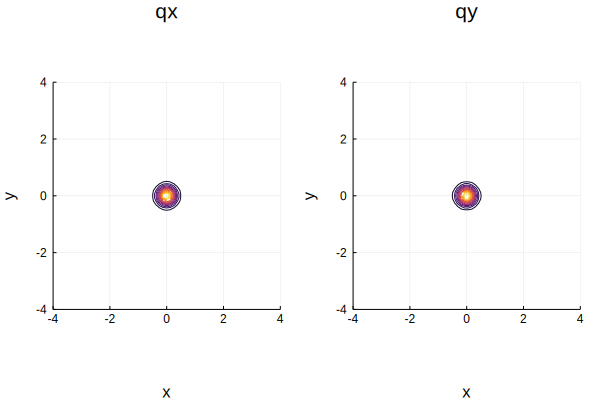

In [22]:
p1 = contour(xedgex.(i_x),yedgex.(j_x),transpose(u0.qx[i_x,j_x]),legend=false,title="qx")
p2 = contour(xedgey.(i_y),yedgey.(j_y),transpose(u0.qy[i_y,j_y]),legend=false,title="qy")
plot(p1,p2,layout=(1,2),xlabel="x",ylabel="y",ratio=1,xlim=(xedgex(1),xedgex(NX+1)),ylim=(yedgey(1),yedgey(NY+1)))

### Set up the time step and the integrator

Set up time step. Note that the maximum grid Fourier number in 2-d will be slightly smaller than in 1-d. (Why?)

In [114]:
Fo = 5 # Fourier number: this choice should be explored!
Δt = Fo*Δx^2/ν 

0.01953125

### Set the integrator.

Here we are setting up a method that will take in (t,u) at one time level and return these values at the next time level:

`t, u = stepper(t,u)`

In [8]:
# Here is what these might look like... The choices below create a new function called `stepper`
# But you need to write the functions `diffuse2d_dirichlet` and `diffuse2d_dirichlet_cn`

# For Runge-Kutta
#stepper = RK(u0,Δt,diffuse2d_dirichlet;rk=RK4)

# or, for Crank-Nicolson
#stepper = diffuse2d_dirichlet_cn

### Solve the problem

Integrate this to final time of tf. Try different final times to explore the evolution of the problem.

In [116]:
tf = 0.1
nsteps = ceil(Int,tf/Δt)

# Initial conditions
t = 0.0
u = deepcopy(u0)

# Set up some arrays to store data
uarray = [deepcopy(u)]
tarray = [t]

# March!
for j = 1:nsteps
    global t, u = stepper(t,u)
    
    # enforce boundary conditions on result
    apply_bc!(u,t)
    
    push!(uarray,deepcopy(u))
    push!(tarray,t)
end

#### For the Gaussian pulse

Compute the exact solution at this final time level

In [73]:
texact = tarray[end]
uexact = EdgeData(u0)
for j in j_e_x, i in i_e_x
    uexact.qx[i,j] = f(xedgex(i),yedgex(j),sqrt(σ^2+4ν*texact))
end
for j in j_e_y, i in i_e_y
    uexact.qy[i,j] = f(xedgey(i),yedgey(j),sqrt(σ^2+4ν*texact))
end

#### For pure boundary data

Compare with the exact solution:

$$f(x,y,t) = \dfrac{2}{\pi} \sin(\pi x)\sum_{n=1}^{\infty}\dfrac{(-1)^n n}{n^2+1} e^{-\nu(n^2+1)\pi^2 t}\sin(n\pi y) + \dfrac{\sin(\pi x)\sinh(\pi y)}{\sinh \pi}$$

In [ ]:
# Evaluate the exact solution, as given in the probme